In [ ]:
from pathlib import Path
import pandas as pd
from io import BytesIO
import sys
import PIL.Image as PILImage
import requests
import random
from termcolor import colored

sys.path.append(str(Path("..").resolve()))
from src import *

# Generate the dataset (Objaverse)
##### ℹ️ This notebook requires `dataset/objaverse/2-annotations_filtered_by_thumbnails.parquet` and `dataset/objaverse/statistics.parquet`, which is generated by `compute_statistics.py`
This notebook generate the dataset as triplets of _rendering_, _UV map_ and _diffuse texture_.
##### ⚠️ This notebook is just a preview of the actual script (see [generate_dataset.py](generate_dataset.py)). The generation of the entire dataset is expensive and thus requires a computation node.

In [ ]:
dataset = ObjaverseDataset3D()

Select only the objects with 1 Mesh, 1 UV map and 1 Diffuse texture

In [ ]:
uids = dataset.statistics[dataset.statistics["valid"]].index

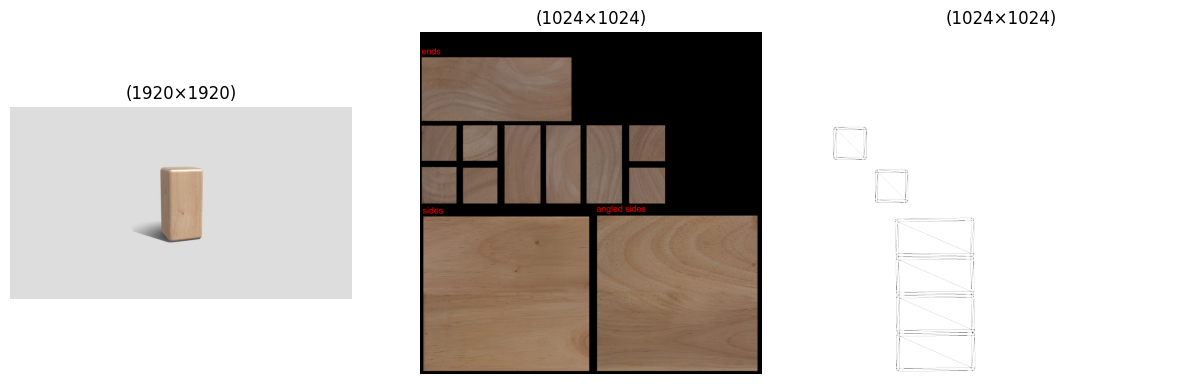

UV density = 0.99% --> TOO LOW


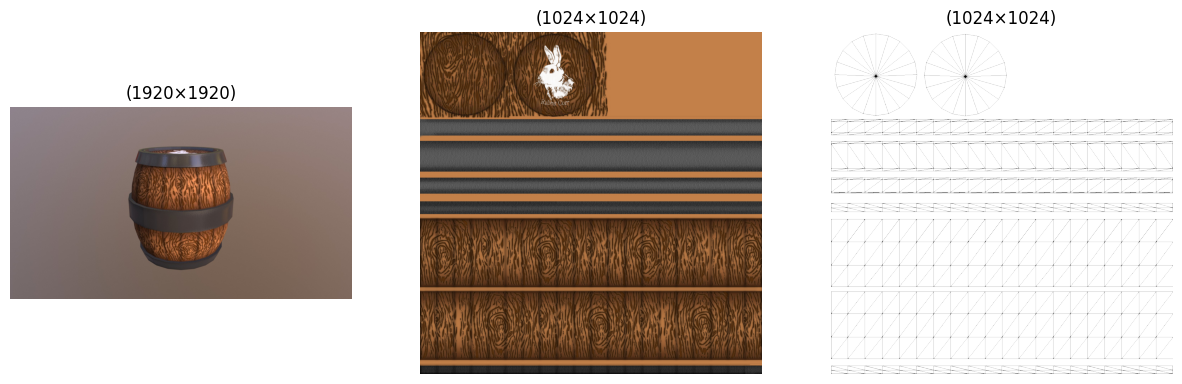

UV density = 6.26% --> OK


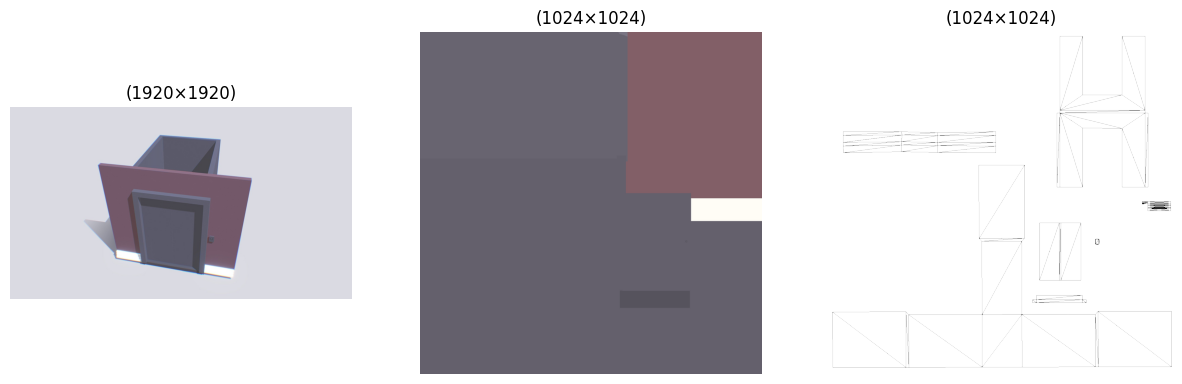

UV density = 1.87% --> OK


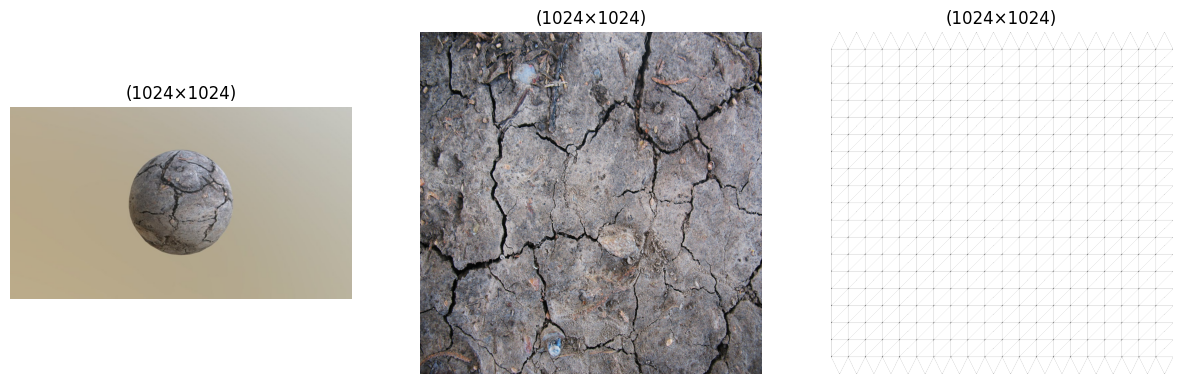

UV density = 5.70% --> OK


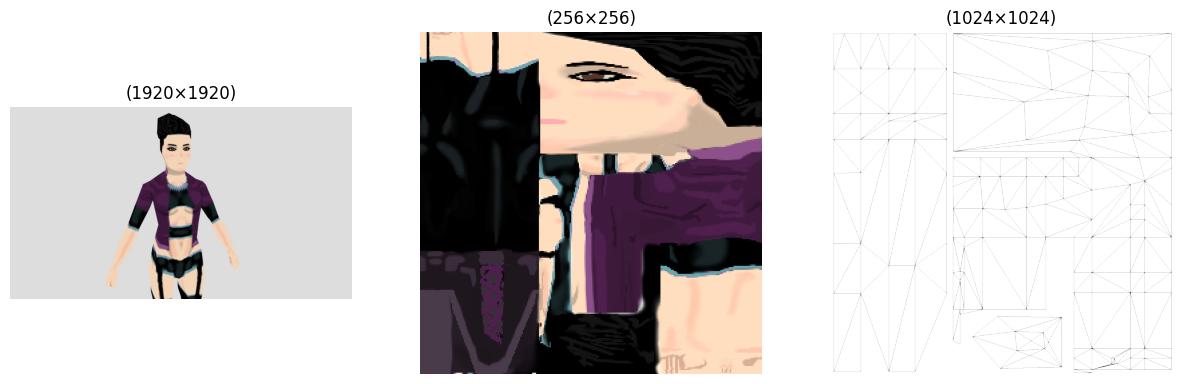

UV density = 3.78% --> OK


In [ ]:
MIN_UV_DENSITY = 0.01
SAMPLES = 5

for uid in uids[random.sample(range(len(uids)), SAMPLES)]:
    obj = dataset[uid]
    rendering = obj.rendering
    diffuse = obj.textures[0]
    uv_map = obj.draw_uv_map()

    plot_images([rendering, diffuse, uv_map], cols=3, size=5)
    uv_density = compute_image_density(uv_map)
    print(
        colored(
            text=f"[{uid}] UV density = {uv_density:.2%} --> {'OK' if uv_density > MIN_UV_DENSITY else 'TOO LOW'}",
            color="green" if uv_density > MIN_UV_DENSITY else "red",
        )
    )